# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from torchvision.datasets import MNIST
trainset = MNIST(root='./data', train=True, download=True, transform=transforms)

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Create training set and define training dataloader
mnist_trainset = MNIST(root='./data', train=True, download=True, transform=transform)

# Create test set and define test dataloader
mnist_testset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create validation set
mnist_valset = MNIST(root='./data', train=False, download=True, transform=transform)

# Define DataLoader for training data
train_loader = DataLoader(
    dataset=mnist_trainset,
    batch_size=64,
    shuffle=True
)

# Define DataLoader for test data
test_loader = DataLoader(
    dataset=mnist_testset,
    batch_size=64,
    shuffle=False
)

# Define DataLoader for validation data
val_loader = DataLoader(
    dataset=mnist_valset,
    batch_size=64,
    shuffle=False
)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

First, I used `ToTensor()`. This transform converts the images from the dataset (which are in the form of PIL images) into PyTorch tensors. PyTorch operaters with tensors, which are multidimensional arrays similar to NumPy arrays, and this conversion is essential for the data to be used in the neural network. Additionally, this step scalses the pixel values from the range [0,255] to [0,1] making the values more manageable for the model.

The next step is to normalize the data, in which I used `Normalize((0.5,), (0.5,))` for. This transform normalizes the image pixel values to fall within the range [-1,1] with a mean of 0.5 and a standard deviation of 0.5 for the single grayscale channel. The original MNIST dataset has pixel values in the range [0,1] after applying `ToTensor()`, and this normalize them to more center range around 0. This process is necessary since it helps improve the training process by ensuring that the input data us centered around 0 and has a standard deviation of 1. Neural network tends to perform better and converge faster when input values are normalized. It also helps avoid issues like vanishing or exploding gradients during backpropagation, which can occur if the input data has vary large or very small values.

So why these specific transforms? I suppose that the combination of converting images to tensors and normalizing the data ensure that the neural network receives the data in an optimal format for learning. Without these steps, the pixel values would be too large since they are in the range of [0,225] without normalization, which would slow down or hinder the network's ability to learn effectively.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    data_iter = iter(img_loader)  # Create an iterator from the DataLoader
    images, labels = data_iter.next()  # Get the first batch of images and labels
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))  # Create a figure with 5 subplots
    
    for i in range(5):
        # Move tensor to CPU and convert to NumPy array for displaying
        img = images[i].numpy().squeeze()  # Remove unnecessary channel dimension
        
        axes[i].imshow(img, cmap='gray')  # Show the image in grayscale
        axes[i].set_title(f"Label: {labels[i].item()}")  # Set the title as the label
        axes[i].axis('off')  # Turn off the axis
    
    plt.show()  # Display the plot

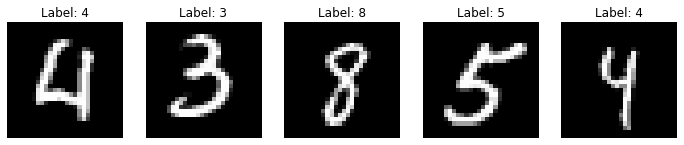

Image shape: torch.Size([1, 28, 28])
Label: 9


In [7]:
# Display 5 sample images from the training dataset
show5(train_loader)

# View image shape and label
data_iter = iter(train_loader)
images, labels = data_iter.next()

# Check the dimensions of one image and one label
print(f"Image shape: {images[0].shape}")  # Should be (1, 28, 28) for MNIST
print(f"Label: {labels[0].item()}")


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),  # Convolutional layer with padding
        nn.ReLU(),                      # Activation function
        nn.AvgPool2d(2, stride=2),      # Pooling layer

        nn.Conv2d(6, 16, 5),            # Another convolutional layer
        nn.ReLU(),                      # Activation function
        nn.AvgPool2d(2, stride=2),      # Pooling layer
        
        nn.Flatten(),                   # Flatten the tensor for fully connected layers
        nn.Linear(400, 120),            # Fully connected layer
        nn.ReLU(),                      # Activation function
        nn.Linear(120, 84),             # Another fully connected layer
        nn.ReLU(),                      # Activation function
        nn.Linear(84, 10)               # Output layer with 10 classes (for MNIST digits)
    )
    return model

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
# Specify the loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = create_lenet().to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=5, print_every=250):
    model.train()  # Set the model to training mode
    train_losses = []  # To record training losses
    val_losses = []    # To record validation losses
    val_accuracies = [] # To record validation accuracies
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        # Training phase
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if (i + 1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss/print_every:.4f}")
                running_loss = 0.0
        
        # Store the average training loss for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase (optional)
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():  # Disable gradient calculation
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        model.train()  # Set the model back to training mode
    
    return train_losses, val_losses, val_accuracies


Plot the training loss (and validation loss/accuracy, if recorded).

Epoch [1/5], Batch [250/938], Loss: 0.7521
Epoch [1/5], Batch [500/938], Loss: 0.2280
Epoch [1/5], Batch [750/938], Loss: 0.1555
Validation Loss: 0.0887, Accuracy: 97.04%
Epoch [2/5], Batch [250/938], Loss: 0.0984
Epoch [2/5], Batch [500/938], Loss: 0.0885
Epoch [2/5], Batch [750/938], Loss: 0.0810
Validation Loss: 0.0593, Accuracy: 98.00%
Epoch [3/5], Batch [250/938], Loss: 0.0653
Epoch [3/5], Batch [500/938], Loss: 0.0587
Epoch [3/5], Batch [750/938], Loss: 0.0598
Validation Loss: 0.0538, Accuracy: 98.20%
Epoch [4/5], Batch [250/938], Loss: 0.0449
Epoch [4/5], Batch [500/938], Loss: 0.0496
Epoch [4/5], Batch [750/938], Loss: 0.0513
Validation Loss: 0.0374, Accuracy: 98.70%
Epoch [5/5], Batch [250/938], Loss: 0.0371
Epoch [5/5], Batch [500/938], Loss: 0.0442
Epoch [5/5], Batch [750/938], Loss: 0.0379
Validation Loss: 0.0352, Accuracy: 98.79%


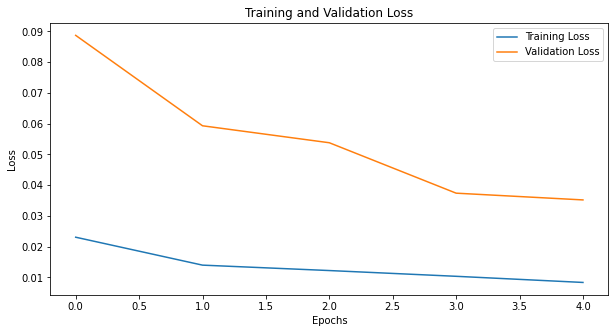

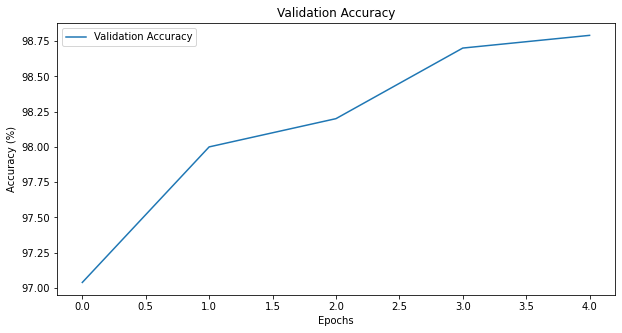

In [11]:
# Train the model and record losses
train_losses, val_losses, val_accuracies = train_model(cnn, train_loader, test_loader, criterion, optimizer, device, epochs=5)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
def test_model(model, test_loader, device):
    model.eval() # Set the model to evaluation mode
    correct = 0 # To track the number of correct predictions
    total = 0 # To track the total number of samples
    
    with torch.no_grad(): # Disable gradient calculation during testing
        for images, labels in test_loader: # Loop through batches in test_loader
            images, labels = images.to(device), labels.to(device) # Move data to the device
            outputs = model(images) # Get predictions from the model
            
            # Get the predicted class (the one with the highest score)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) # Count the total number of samples
            correct += (predicted == labels).sum().item() # Count correct predictions
    # Compute the accuracy as a percentage
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')
    
    return accuracy

In [13]:
test_accuracy = test_model(cnn, test_loader, device)

Accuracy on the test set: 98.79%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Epoch [1/6], Batch [250/938], Loss: 0.8533
Epoch [1/6], Batch [500/938], Loss: 0.2727
Epoch [1/6], Batch [750/938], Loss: 0.1922
Validation Loss: 0.1250, Accuracy: 95.81%
Epoch [2/6], Batch [250/938], Loss: 0.1289
Epoch [2/6], Batch [500/938], Loss: 0.1156
Epoch [2/6], Batch [750/938], Loss: 0.0972
Validation Loss: 0.0770, Accuracy: 97.51%
Epoch [3/6], Batch [250/938], Loss: 0.0834
Epoch [3/6], Batch [500/938], Loss: 0.0732
Epoch [3/6], Batch [750/938], Loss: 0.0799
Validation Loss: 0.0649, Accuracy: 97.84%
Epoch [4/6], Batch [250/938], Loss: 0.0649
Epoch [4/6], Batch [500/938], Loss: 0.0644
Epoch [4/6], Batch [750/938], Loss: 0.0575
Validation Loss: 0.0514, Accuracy: 98.28%
Epoch [5/6], Batch [250/938], Loss: 0.0567
Epoch [5/6], Batch [500/938], Loss: 0.0471
Epoch [5/6], Batch [750/938], Loss: 0.0480
Validation Loss: 0.0389, Accuracy: 98.64%
Epoch [6/6], Batch [250/938], Loss: 0.0396
Epoch [6/6], Batch [500/938], Loss: 0.0425
Epoch [6/6], Batch [750/938], Loss: 0.0428
Validation Loss:

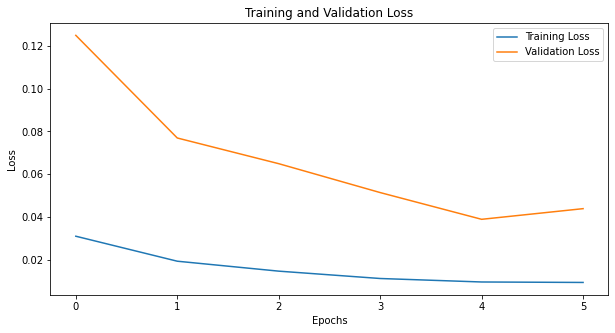

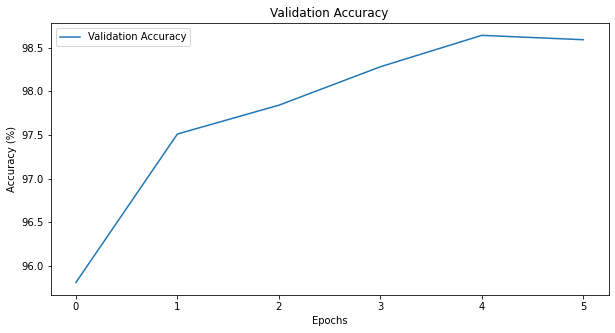

In [14]:
# Specify the loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = create_lenet().to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(cnn.parameters(), lr=5e-4)  # Lower learning rate for better convergence

# Increase epochs to give the model more time to train, but not too high to avoid overfit. I increased to 10 and val loss starts to
# to increase, so I cut down to 6
train_losses, val_losses, val_accuracies = train_model(cnn, train_loader, test_loader, criterion, optimizer, device, epochs=6)


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
# Define the path where I want to save the model
model_save_path = './mnist_model.pth'

# Save the model's state_dict
torch.save(cnn.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to ./mnist_model.pth
